In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib

In [10]:
def load_and_prepare_data(seed_dir, seeds_train,
                         is_filename=False):
    train_df = []
    for i in seeds_train:
        if is_filename:
            seed_df = pd.read_csv(i)
        else:
            seed_df = pd.read_csv(seed_dir+f'seir_seed_{i}.csv')
        seed_df = seed_df[(seed_df['E'] > 0)|(seed_df['I'] > 0)].copy()
        seed_df = seed_df[seed_df['Beta'] > 0].copy()
        
        seed_df['prev_I'] = seed_df['I'].shift(1).fillna(0)
        seed_df['day'] = np.arange(len(seed_df))
        train_df.append(seed_df)
    
    train_df = pd.concat(train_df, ignore_index=True)
    #train_df = train_df[train_df['Beta'] > 0].copy()
    
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].replace(0, 1e-7)
    #train_df.loc[:,'Beta'] = train_df.loc[:,'Beta'].fillna(1e-7)
    #train_df = train_df[(train_df['E'] > 0)|(train_df['I'] > 0)].copy()
    train_df['log_Beta'] = np.log(train_df['Beta'])
    return train_df


def train_model(train_df, model_file,features):
    X = train_df[features].values
    y = train_df['log_Beta'].values

    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(include_bias=False, degree=3),
        SGDRegressor(alpha=0.0001, max_iter=8000, penalty='l2',warm_start=False)
    )
    model.fit(X, y)
    print(model.score(X, y))
    # Сохраняем лучшую модель
    joblib.dump(model, model_file)

    
def plot(model_file, features):
    model = joblib.load(model_file)
    X = train_df[features].values
    y = train_df['log_Beta'].values
    pred = model.predict(X)
    
    fig = plt.figure(figsize=(5, 3)) 
    plt.plot(y, ls='', marker='.')
    plt.plot(pred, ls='', marker='.')
    plt.grid()


In [5]:
df_seeds = pd.read_csv('initial_data/seeds_set_parameters.csv')
seeds_train = df_seeds[df_seeds.set!='test']['seed_number'].values
features = ['day', 
            'prev_I', 
            'S', 'E', 'I', 'R']

## barabasi-albert

0.74009982634585


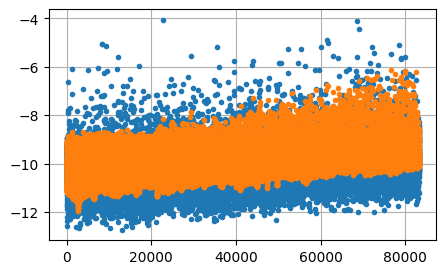

In [69]:
seed_dir='initial_data/initial_data_ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'


train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.767961501920597


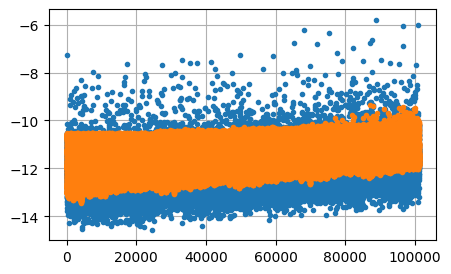

In [70]:
seed_dir='initial_data/initial_data_ba_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.7742044013608336


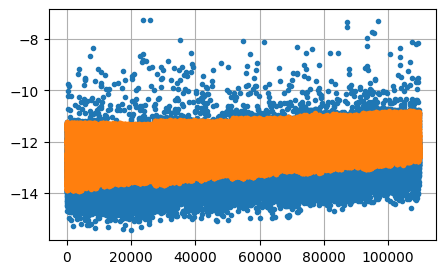

In [71]:
seed_dir='initial_data/initial_data_ba_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

### new

D:\Programs\Anaconda\envs\abm_seir\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


-3068295.804415424


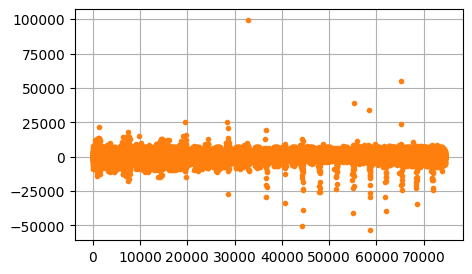

In [11]:
df_seeds_n = pd.read_csv('initial_data/new_seeds_parameters.csv')
seeds_train_n = df_seeds_n[df_seeds_n.set!='test']['file'].values
features = ['day', 
            'prev_I', 
            'S', 'E', 'I', 'R']

seed_dir='initial_data/ba_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train_n,
                                is_filename=True)
train_model(train_df, model_file, features)
plot(model_file, features)

## small world

0.7831986579904753


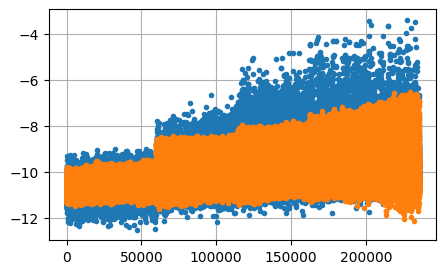

In [73]:
seed_dir='initial_data/initial_data_sw_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.7995411630648883


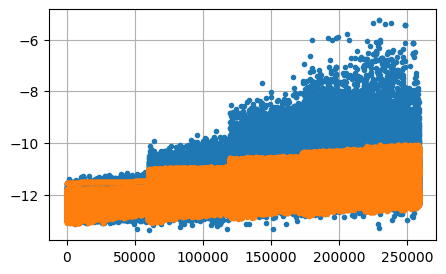

In [84]:
seed_dir='initial_data/initial_data_sw_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.8006524916040959


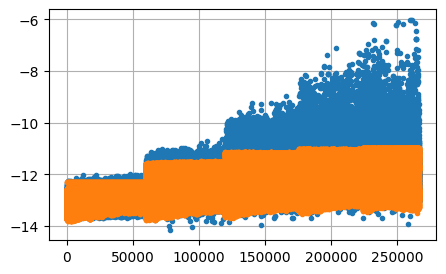

In [86]:
seed_dir='initial_data/initial_data_sw_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

## random

0.47265593949212037


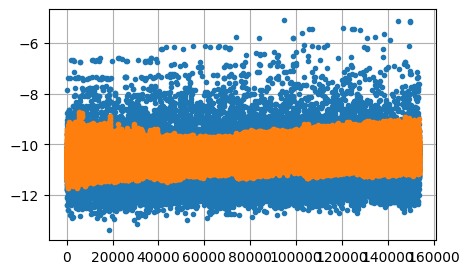

In [76]:
seed_dir='initial_data/initial_data_r_10000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.39236605160335125


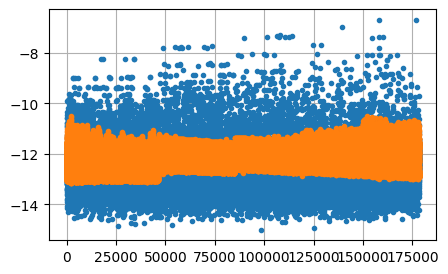

In [77]:
seed_dir='initial_data/initial_data_r_50000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)

0.506706635398467


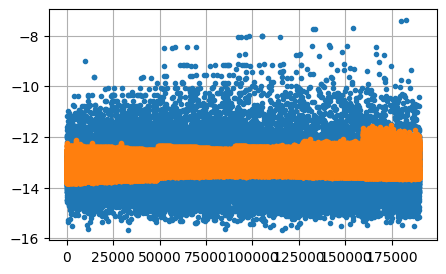

In [79]:
seed_dir='initial_data/initial_data_r_100000/'
model_file = seed_dir+'regression_day_SEIR_prev_I_for_seir.joblib'

train_df = load_and_prepare_data(seed_dir, seeds_train)
train_model(train_df, model_file, features)
plot(model_file, features)